## Kaggle Titanic ML Competition
Goals: use deep learning to create a model that predicts which passengers survived the Titanic shipwreck.
1. Data Cleaning: 
* check missing values (train+test)
* deal with missing "Age": fill in with average by Title (new feature) 
* deal with missing "Embarked":dropna
* create new features for EDA or training: age group and family size 
* drop irrelavent columns: "Cabin", "Ticket"
2. EDA: analyze count/distribution/percentage of survivors in terms of (train)
* gender 
* port, port+class
* age group, age group+gender
* class,class+identity(new feature),
3. Feature Engineering: (train+test)
* get dummy variables for categorical variables: 'Sex', 'Embarked', 'Pclass'
* drop irrelavent columns for training: 'PassengerId','Name','AgeGroup','Title','Identity'
* normalize age and Fare
* plot correlation matrix for train data
* normalize binary labels by LabelBinarizer 
* split train and test data from Train and use Test as validation and submission
4. Modeling neural network with backpropagation from scratch
* 4.1 Build Backpropagation Algorithm from scratch
* 4.2 Application of Backpropagation
* 4.3 Define Evaluation Metrcis
* 4.4 Implement the neural network
5. Make Predictions for submission

### Import libraries and dataset 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#allow plots and visualisations to be displayed in the report
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


There are 11 features and 1 label (Survived). 
* PassengerId: integer
* Survivied: 0:No, 1:Yes
* Pclass: ticket class; 1 = 1st, 2 = 2nd, 3 = 3rd
* Name: first name, title, last name
* Sex: male, female
* Age: float
* SibSp: # of siblings aboard the Titanic
* Parch: # of parents aboard the Titanic
* Ticket: ticket number in letters and numbers
* Fare: passenger fare in float
* Cabin: cabin location number 
* Embarked: port of embarkation; C = Cherbourg, Q = Queenstown, S = Southampton

def write_prediction(prediction, name):
    PassengerId = np.array(test['PassengerId']).astype(int)
    solution = pd.DataFrame(prediction, PassengerId, columns = ['Survived'])
    solution.to_csv(name, index_label = ['PassengerId'])

### 1.Data Cleaning and Data Understanding

#### 1.1 Check Missing Values

From the above overview, we can tell Column "Name" contains multiple format of names, including titles and parentheses.

In [5]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null 

From the above info, we can tell Columns "Age","Embarked","Cabin" have many missing values: 
* For missing Age: I plan to fill with average age in terms of their titles so that the average age might be closer the the actual age.
* For missing Embarked: Since there are only 2 missing values in the train dataset, and 1 missing value in the test dataset, I will drop the rows with missing Embarked values.
* For missing Cabin: Since this feature is not concerned for model training and this feature has over 75% of missing data , we will not fill in values and will drop the column later.

#### 1.2 Deal with missing Ages

In [6]:
#Use Regular Expression to get the title from the Name field
import re
pattern = re.compile(r'.*?,(.*?)\.')
def getTitle(x):
    result = pattern.search(x)
    if result:
        return result.group(1).strip()
    else:
        return ''

train['Title'] = train['Name'].map(getTitle)
test['Title'] = test['Name'].map(getTitle)

#Check number of rows with missing Age field by Title
print(train['Title'][train['Age'].isnull()].value_counts())
print(test['Title'][test['Age'].isnull()].value_counts())

Mr        119
Miss       36
Mrs        17
Master      4
Dr          1
Name: Title, dtype: int64
Mr        57
Miss      14
Mrs       10
Master     4
Ms         1
Name: Title, dtype: int64


From the above info, we extract 5 types of titles, "Mr", "Miss", "Mrs", "Master", "Dr"

In [7]:
#Set the missing Age of Title 'Master' 
master_age_mean = train['Age'][(train['Title']=='Master')&(train['Age']>0)].mean()
train.loc[train[(train['Title']=='Master')&(train['Age'].isnull())].index, 'Age'] = master_age_mean
test.loc[test[(test['Title']=='Master')&(test['Age'].isnull())].index, 'Age'] = master_age_mean

#Set the missing Age of Title 'Mr' 
mr_age_mean = train['Age'][(train['Title']=='Mr')&(train['Age']>0)].mean()
train.loc[train[(train['Title']=='Mr')&(train['Age'].isnull())].index, 'Age'] = mr_age_mean
test.loc[test[(test['Title']=='Mr')&(test['Age'].isnull())].index, 'Age'] = mr_age_mean

#Set the missing Age of Title 'Miss'
miss_age_mean = train['Age'][(train['Title']=='Miss')&(train['Age']>0)].mean()
train.loc[train[(train['Title']=='Miss')&(train['Age'].isnull())].index, 'Age'] = miss_age_mean
test.loc[test[((test['Title']=='Miss')|(test['Title']=='Ms'))&(test['Age'].isnull())].index, 'Age'] = miss_age_mean

#Set the missing Age of Title 'Mrs' 
mrs_age_mean = train['Age'][(train['Title']=='Mrs')&(train['Age']>0)].mean()
train.loc[train[(train['Title']=='Mrs')&(train['Age'].isnull())].index, 'Age'] = mrs_age_mean
test.loc[test[(test['Title']=='Mrs')&(test['Age'].isnull())].index, 'Age'] = mrs_age_mean

#Set the missing Age of Title 'Dr' 
dr_age_mean = train['Age'][(train['Title']=='Dr')&(train['Age']>0)].mean()
train.loc[train[(train['Title']=='Dr')&(train['Age'].isnull())].index, 'Age'] = dr_age_mean
test.loc[test[(test['Title']=='Mrs')&(test['Age'].isnull())].index, 'Age'] = dr_age_mean

print(train['Age'].describe())
print(test['Age'].describe())

count    891.000000
mean      29.754659
std       13.277179
min        0.420000
25%       21.773973
50%       30.000000
75%       35.898148
max       80.000000
Name: Age, dtype: float64
count    418.000000
mean      30.142031
std       13.034817
min        0.170000
25%       21.830479
50%       30.000000
75%       35.974537
max       76.000000
Name: Age, dtype: float64


From the above description, we can tell:
* Count of Age field for both train and test data are matching with number of passenger. 
* Range for Age is (0,80)

#### 1.3 Deal with missing Embarked

In [8]:
missing_ports = train[train['Embarked'].isnull()]
missing_ports

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs


There are only 2 missing ports in the whole dataset, and from the above info, the two passenegers shared the same ticket number and cabin. I googled name Stone, Mrs. George Nelson and found the historical record that they both embarded from Southampton. Thus, I manully filled in "S" to the missing Embarked. 

In [9]:
# Filling the missing values in Embarked with S
train['Embarked'] = train['Embarked'].fillna('S')

#### 1.4 Create new features

#### Age Group

In [10]:
#create age group and explore age groups instead of individual ages  
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-80']
train['AgeGroup'] = pd.cut(train.Age, range(0, 82, 10), right=False, labels=age_labels)
test['AgeGroup'] = pd.cut(test.Age, range(0, 82, 10), right=False, labels=age_labels)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
Title          891 non-null object
AgeGroup       890 non-null category
dtypes: category(1), float64(2), int64(5), object(6)
memory usage: 91.9+ KB


In [12]:
missing_age=train[train['AgeGroup'].isnull()]
missing_age

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0,A23,S,Mr,NaN


In [13]:
# Filling the missing values in AgeGroup with 70-80
train['AgeGroup'] = train['AgeGroup'].fillna('70-80')

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
Title          891 non-null object
AgeGroup       891 non-null category
dtypes: category(1), float64(2), int64(5), object(6)
memory usage: 91.9+ KB


#### Family Size

In [15]:
# add FamilySize: sum of SibSp and Parch
train['FamilySize'] = train['SibSp'] + train['Parch']
test['FamilySize'] = test['SibSp'] + test['Parch']

#### 1.5 Drop irrelavent columns

In [16]:
# dropping columns Cabin and Ticket
train = train.drop(['Cabin','Ticket'], axis=1)
test = test.drop(['Cabin','Ticket'], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       891 non-null object
Title          891 non-null object
AgeGroup       891 non-null category
FamilySize     891 non-null int64
dtypes: category(1), float64(2), int64(6), object(4)
memory usage: 84.9+ KB


In [17]:
train["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

### 2.Exploratory Data Analysis

In [18]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked', 'Title', 'AgeGroup', 'FamilySize'],
      dtype='object')

explore survival distribution with respect to Pclass, Sex, Age, SibSp, Parch, Fare, Embarked

#### 2.1 Explore survival distribution by gender

#### Pie Chart: Survival percentage grouped by gender

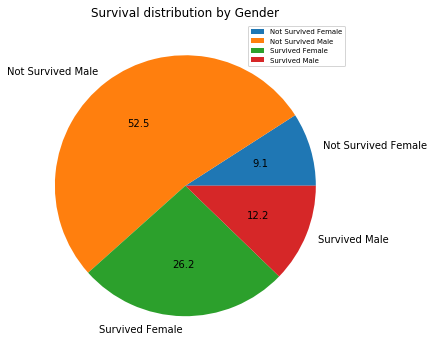

In [19]:
fig, ax = plt.subplots(figsize = (6,6))
patches, l_texts, p_texts = ax.pie(train.groupby(['Survived', 'Sex']).size(), 
        labels=['Not Survived Female', 'Not Survived Male', 'Survived Female', 'Survived Male'],
        autopct='%3.1f', labeldistance = 1.1,pctdistance = 0.6)
plt.legend(loc='best', fontsize='x-small')
ax.set_title('Survival distribution by Gender')
for t in l_texts:
    t.set_size(10)
for p in p_texts:
    p.set_size(10)

##### Observations as below:
* More than half of them are not survived male 
* Less than 10% of them are not survived female 

#### Percentage and Count of survivors by gender 

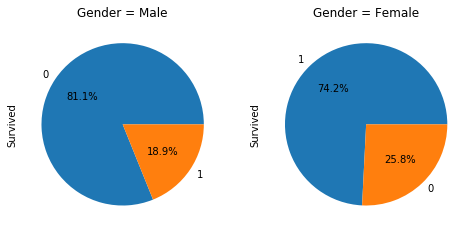

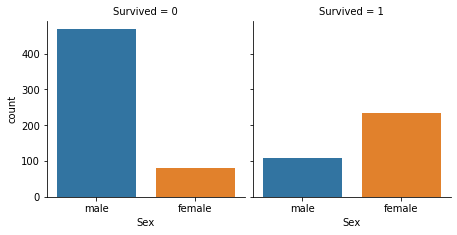

In [20]:
fig,ax=plt.subplots(1,2,figsize=(8,10))
male=train['Survived'][train['Sex']=='male'].value_counts()
female=train['Survived'][train['Sex']=='female'].value_counts()
ax[0]=male.plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=False) #explode=[0,0.2]
ax[1]=female.plot.pie(autopct='%1.1f%%',ax=ax[1],shadow=False) #explode=[0,0.2]
ax[0].set_title('Gender = Male')
ax[1].set_title('Gender = Female')

count_plt=sns.catplot(x='Sex', col='Survived', kind='count', data=train)
count_plt.fig.set_figwidth(6)
count_plt.fig.set_figheight(3)

plt.show()

In [21]:
print(f"Survival Count of Male Passenger: ")
print(male)
print(f"Survival Count of Female Passenger: ")
print(female)

Survival Count of Male Passenger: 
0    468
1    109
Name: Survived, dtype: int64
Survival Count of Female Passenger: 
1    233
0     81
Name: Survived, dtype: int64


##### Observations as below:
* There are significantly more male passengers then female passengers on board.
* The pie chart presenting percentage of survivors by gender shows that 74.2% of all females are survived, but only 18.9% of males are survived regardless of other factors.

#### 2.2 Explore Survival distribution by the embarked port

#### Survival Percentage by each embarked port 

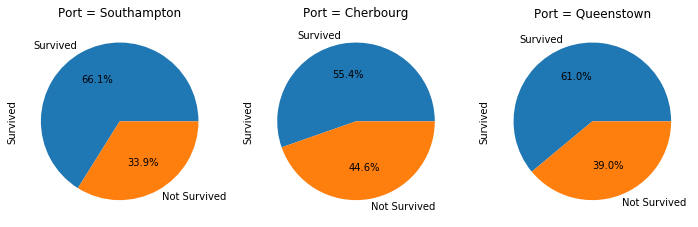

In [22]:
fig,ax=plt.subplots(1,3,figsize=(12,12))
labels=["Survived","Not Survived"]

s=train['Survived'][train['Embarked']=='S'].value_counts()
c=train['Survived'][train['Embarked']=='C'].value_counts()
q=train['Survived'][train['Embarked']=='Q'].value_counts()

ax[0]=s.plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=False,labels=labels) #explode=[0,0.2]
ax[1]=c.plot.pie(autopct='%1.1f%%',ax=ax[1],shadow=False,labels=labels) #explode=[0,0.2],ax=ax[1]
ax[2]=q.plot.pie(autopct='%1.1f%%',ax=ax[2],shadow=False,labels=labels) #ax=ax[2]

#C = Cherbourg, Q = Queenstown, S = Southampton
ax[0].set_title('Port = Southampton')
ax[1].set_title('Port = Cherbourg')
ax[2].set_title('Port = Queenstown')

plt.show()

#### Survival Rate for each port grouped by ticket class(Pclass)

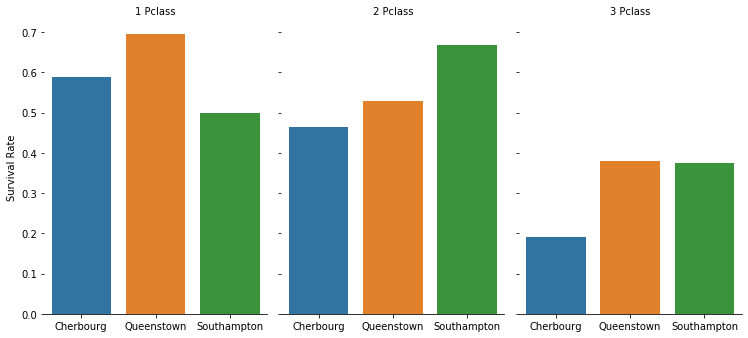

In [23]:
port_name=["Cherbourg", "Queenstown", "Southampton"]
g = sns.catplot(x="Embarked", y="Survived", col="Pclass", data=train,
                kind="bar", ci=None, aspect=.7)  #saturation=.5
g.set_axis_labels("", "Survival Rate")
g.set_xticklabels(port_name)
g.set_titles("{col_name} {col_var}")
g.despine(left=True)

#### Observations:
* For the first class ticket, passengers boarded from Queestown have the highest survival rate; 
* For the second class ticket, passengers boarded from Southampton have the highest survival rate;
* For the third class ticket, passengers boarded from Queestown and Southampton have similar survival rate higher than the Cherbourg
* In general, boarding from Queenstown with the first class ticket has the highest survival rate.

#### 2.3 Explore survival distribution by age

#### Check distribution of age groups

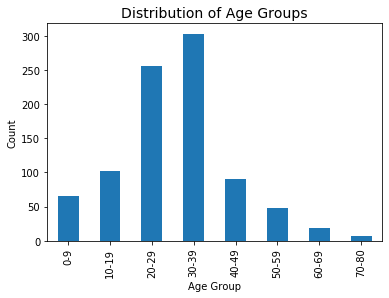

In [24]:
#create age group and explore 
# age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
# train['age_group'] = pd.cut(train.Age, range(0, 81, 10), right=False, labels=age_labels)

train.groupby(['AgeGroup']).size().plot(kind='bar',stacked=True)
plt.title("Distribution of Age Groups",fontsize=14)
plt.ylabel('Count')
plt.xlabel('Age Group')

plt.show()

#### Count of survivors by age group

In [25]:
#calculate percentage
def calculate_percentage(val, total, format_percent = False):
    """Calculates the percentage of a value over a total"""
    percent = np.divide(val, total, dtype=float)
    if format_percent:
        percent = as_percent(percent)
    return percent

# calculate values for each survival status
grouped = train.groupby(['Survived'])
group0 = grouped.get_group(0) #not survived group
group1 = grouped.get_group(1) #survived group

age_group_1 = group1.groupby(['AgeGroup']).size().values
age_group_0 = group0.groupby(['AgeGroup']).size().values

# calculate totals for percentates
totals = age_group_0 + age_group_1

# use calculate_percentage_function to calculate percentage of the total
percentage1 = calculate_percentage(age_group_1, totals)*100 
percentage0 = calculate_percentage(age_group_0, totals)*100 

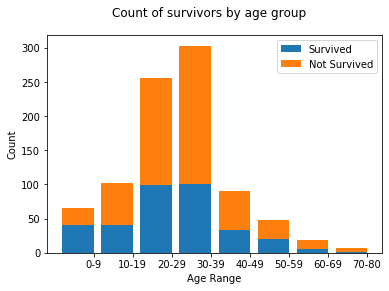

In [26]:
tick_spacing = np.array(range(len(age_labels)))+0.4

# plot chart for count of survivors by class
fig, ax = plt.subplots()
ax1=ax.bar(range(len(age_group_1)), age_group_1, label='Survived') #color='g',alpha=0.5
ax2=ax.bar(range(len(age_group_0)), age_group_0, bottom=age_group_1, label='Not Survived') #color='r',alpha=0.5
plt.xticks(tick_spacing, age_labels )
ax.set_ylabel("Count")
ax.set_xlabel("Age Range")
plt.suptitle("Count of survivors by age group",fontsize=12)
plt.legend(loc='upper right')

plt.show()

#### Percentage of survivors by Age Group and Gender

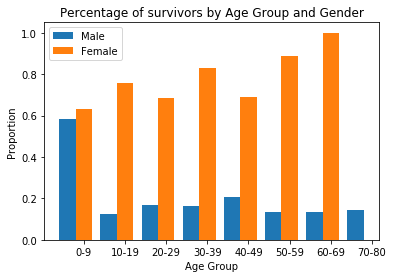

In [27]:
male = train[train.Sex == "male"].groupby('AgeGroup').Survived.mean().values
female = train[train.Sex == "female"].groupby('AgeGroup').Survived.mean().values
ax = plt.subplot()
male_plt_position = np.array(range(len(age_labels)))
female_plt_position = np.array(range(len(age_labels)))+0.4
ax.bar(male_plt_position, male, width=0.4,label='Male')#color='b'
ax.bar(female_plt_position, female, width=0.4,label='Female')#color='r'
plt.xticks(tick_spacing,  age_labels)
ax.set_ylabel("Proportion")
ax.set_xlabel("Age Group")
ax.set_title("Percentage of survivors by Age Group and Gender",fontsize=12)
plt.legend(loc='best')
plt.show()

#### Obervations:
* Females from all age ranges have a significant larger proportion of survivors compared with males
* All genders in the age 0-9 have a large proportion of survival rates which shows that children also had a priority on boarding to lifeboats 

To further analyze the data on gender and age range, I create a new feature "Identity" defined by women, men and children 

In [28]:
def getIdentity(row):
    if row["Age"] < 19.0:
        return "children"
    if row["Age"] >= 19.0 and row["Sex"] == "male":
        return "male"
    else:
        return "female"
train["Identity"]=train.apply(lambda row: getIdentity(row), axis=1)

#### 2.4 Explore Survival distribution by class and identity

#### Count of survivors and distribution of survival rate

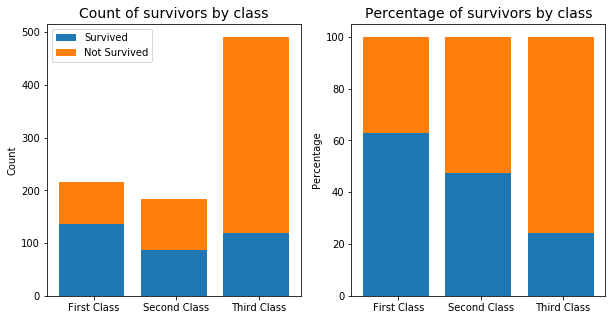

In [81]:
# calculate values for each survival status
grouped = train.groupby(['Survived'])
group0 = grouped.get_group(0) #not survived group
group1 = grouped.get_group(1) #survived group

class_group_1 = group1.groupby(['Pclass']).size().values
class_group_0 = group0.groupby(['Pclass']).size().values

# survivors_class = survivors_data.groupby(['Pclass']).size().values
# non_survivors_class = non_survivors_data.groupby(['Pclass']).size().values

# calculate totals for percentates
totals = class_group_0 + class_group_1

# use calculate_percentage_function to calculate percentage of the total
percentage1 = calculate_percentage(class_group_1, totals)*100 
percentage0 = calculate_percentage(class_group_0, totals)*100 


class_categories = ['First Class', 'Second Class','Third Class']


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
# plot chart for count of survivors by class
ax1.bar(range(len(class_group_1)), class_group_1, label='Survived')#color='g'
ax1.bar(range(len(class_group_0)), class_group_0, bottom=class_group_1, label='Not Survived')# color='r'
plt.sca(ax1)
plt.xticks([0.03, 1.03, 2.03], class_categories )
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title("Count of survivors by class",fontsize=14)
plt.legend(loc='upper left')

# plot chart for percentage of survivors by class
ax2.bar(range(len(percentage1)), percentage1)#color='g',alpha=0.5
ax2.bar(range(len(percentage0)), percentage0, bottom=percentage1)#color='r'
plt.sca(ax2)
plt.xticks([0.03, 1.03, 2.03],  class_categories)
ax2.set_ylabel("Percentage")
ax2.set_xlabel("")
ax2.set_title("Percentage of survivors by class",fontsize=14)

plt.show()

#### Survival Rate grouped by class and identity

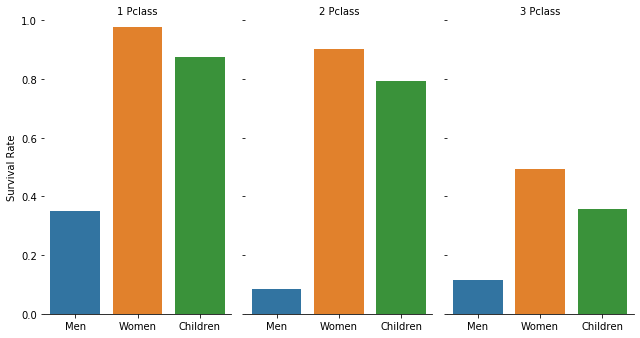

In [30]:
g = sns.catplot(x="Identity", y="Survived", col="Pclass", data=train,
                kind="bar", ci=None, aspect=.6)  #saturation=.5
g.set_axis_labels("", "Survival Rate")
g.set_xticklabels(["Men", "Women", "Children"])
g.set_titles("{col_name} {col_var}")
g.set(ylim=(0, 1))
g.despine(left=True)

#### 3. Feature Engineering

In [31]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeGroup,FamilySize,Identity
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr,20-29,1,male
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs,30-39,1,female
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss,20-29,0,female
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs,30-39,1,female
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr,30-39,0,male


In [32]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeGroup,FamilySize
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,Mr,30-39,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,Mrs,40-49,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,Mr,60-69,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,Mr,20-29,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,Mrs,20-29,2


In [33]:
Train = train.copy()
Test = test.copy()

#### 3.1 Get dummy variables and Drop Irrelavent columns for training 

In [34]:
Train=pd.get_dummies(Train,columns=['Sex', 'Embarked', 'Pclass'],drop_first=True)
Test=pd.get_dummies(test,columns=['Sex', 'Embarked', 'Pclass'],drop_first=True)

In [35]:
Train.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Fare,Title,AgeGroup,FamilySize,Identity,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,Mr,20-29,1,male,1,0,1,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,Mrs,30-39,1,female,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,Miss,20-29,0,female,0,0,1,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,Mrs,30-39,1,female,0,0,1,0,0
4,5,0,"Allen, Mr. William Henry",35.0,0,0,8.0500,Mr,30-39,0,male,1,0,1,0,1


In [36]:
Test.head()

,PassengerId,Name,Age,SibSp,Parch,Fare,Title,AgeGroup,FamilySize,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,892,"Kelly, Mr. James",34.5,0,0,7.8292,Mr,30-39,0,1,1,0,0,1
1,893,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,7.0000,Mrs,40-49,1,0,0,1,0,1
2,894,"Myles, Mr. Thomas Francis",62.0,0,0,9.6875,Mr,60-69,0,1,1,0,1,0
3,895,"Wirz, Mr. Albert",27.0,0,0,8.6625,Mr,20-29,0,1,0,1,0,1
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,12.2875,Mrs,20-29,2,0,0,1,0,1


In [37]:
#for train data:
Train.drop([],axis=1,inplace=True)

#for test data:
test_passengerid=test['PassengerId']
Test.drop(['PassengerId','Name','AgeGroup','Title'],axis=1,inplace=True)

In [38]:
Train.head()

,Survived,Age,SibSp,Parch,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,1,1,0,1,0,1
1,1,38.0,1,0,71.2833,1,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,0,0,1,0,1
3,1,35.0,1,0,53.1000,1,0,0,1,0,0
4,0,35.0,0,0,8.0500,0,1,0,1,0,1


In [39]:
Test.head()

,Age,SibSp,Parch,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,34.5,0,0,7.8292,0,1,1,0,0,1
1,47.0,1,0,7.0000,1,0,0,1,0,1
2,62.0,0,0,9.6875,0,1,1,0,1,0
3,27.0,0,0,8.6625,0,1,0,1,0,1
4,22.0,1,1,12.2875,2,0,0,1,0,1


In [40]:
#for train data:
Train.drop(['SibSp','Parch'],axis=1,inplace=True)

#for test data:
Test.drop(['SibSp','Parch'],axis=1,inplace=True)

In [41]:
Train.head()

,Survived,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,0,22.0,7.2500,1,1,0,1,0,1
1,1,38.0,71.2833,1,0,0,0,0,0
2,1,26.0,7.9250,0,0,0,1,0,1
3,1,35.0,53.1000,1,0,0,1,0,0
4,0,35.0,8.0500,0,1,0,1,0,1


#### 3.2 Correlation Matrix

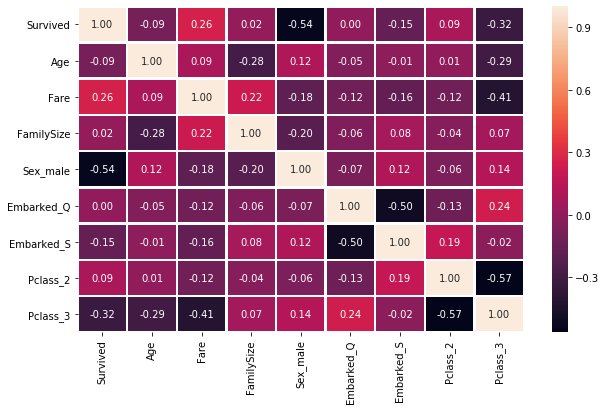

In [42]:
corr = Train.corr()

f,ax = plt.subplots(figsize=(10,6))
sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax)
plt.show()

#### 3.3 Data Normalization 

* The scale for input value "Age" and "Fare" vary, so data normalization is required for use with sklearn MinMaxScaler before feed input into neural network.
* With MinMaxScaler, input values are scaled to range 0-1
* With LabelBinarizer, output classes are normalized to binary classes.

In [43]:
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer

minmax_scaler=MinMaxScaler()
Train["Age"]=minmax_scaler.fit_transform(Train["Age"].values.reshape(-1,1))
Test["Age"]=minmax_scaler.fit_transform(Test["Age"].values.reshape(-1,1))

In [44]:
Train["Fare"]=minmax_scaler.fit_transform(Train["Fare"].values.reshape(-1,1))
Test["Fare"]=minmax_scaler.fit_transform(Test["Fare"].values.reshape(-1,1))

In [45]:
Train.head()

,Survived,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,0,0.271174,0.014151,1,1,0,1,0,1
1,1,0.472229,0.139136,1,0,0,0,0,0
2,1,0.321438,0.015469,0,0,0,1,0,1
3,1,0.434531,0.103644,1,0,0,1,0,0
4,0,0.434531,0.015713,0,1,0,1,0,1


In [46]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived      891 non-null int64
Age           891 non-null float64
Fare          891 non-null float64
FamilySize    891 non-null int64
Sex_male      891 non-null uint8
Embarked_Q    891 non-null uint8
Embarked_S    891 non-null uint8
Pclass_2      891 non-null uint8
Pclass_3      891 non-null uint8
dtypes: float64(2), int64(2), uint8(5)
memory usage: 32.3 KB


In [47]:
Train.describe()

,Survived,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,0.368618,0.062858,0.904602,0.647587,0.086420,0.725028,0.206510,0.551066
std,0.486592,0.166841,0.096995,1.613459,0.477990,0.281141,0.446751,0.405028,0.497665
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.268333,0.015440,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.371701,0.028213,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,1.000000,0.445817,0.060508,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
Test.head()

,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,0.452723,0.015282,0,1,1,0,0,1
1,0.617566,0.013663,1,0,0,1,0,1
2,0.815377,0.018909,0,1,1,0,1,0
3,0.353818,0.016908,0,1,0,1,0,1
4,0.287881,0.023984,2,0,0,1,0,1


#### 3.4 Split train and test from Train, and use Test as validation datset

In [49]:
from sklearn.model_selection import train_test_split
X = Train.drop('Survived',axis=1)
lb=LabelBinarizer()
y = lb.fit_transform(Train["Survived"])

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [51]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"There are {X_train.shape[0]} records with {X_train.shape[1]} numerical input variables and 2 output classes.")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (712, 8)
Shape of y_train: (712, 1)
There are 712 records with 8 numerical input variables and 2 output classes.
Shape of X_test: (179, 8)
Shape of y_test: (179, 1)


In [52]:
X_train.head()

,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
331,0.566474,0.055628,0,1,0,1,0,0
733,0.283740,0.025374,0,1,0,1,1,0
382,0.396833,0.015469,0,1,0,1,0,1
704,0.321438,0.015330,1,1,0,1,0,1
813,0.070118,0.061045,6,0,0,1,0,1


In [53]:
X_train=X_train.values.tolist()

#### 4. Modelling

In [54]:
from random import randrange,randint
from random import random
from math import exp

#### 4.1 Build Backpropagation Algorithm from scratch 

In [55]:
#1.Calculate neuron activation for an input
def activate(weights, inputs):
    activation = weights[-1] #assume that the bias is the last weight in the list of weights
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i] #Neuron activation is calculated as the weighted sum of the inputs
    return activation
 
#2.Transfer neuron activation
def transfer(activation):
    return 1.0 / (1.0 + exp(-activation)) #apply sigmoid function as activation function, produce numbers btw 0-1
 
#3.Forward propagate input to a network output
def forward_propagate(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs
 
#4.Calculate the derivative of an neuron output
def transfer_derivative(output):
    return output * (1.0 - output)
 
#5.Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = list()
        if i != len(network)-1:
            for j in range(len(layer)):
                error = 0.0
                for neuron in network[i + 1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error)
        else:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append(expected[j] - neuron['output'])
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * transfer_derivative(neuron['output']) 
            #delta: store error signal for each neuron
            
#6.Update network weights with error
def update_weights(network, row, l_rate):# weight = weight + learning_rate * error * input
    for i in range(len(network)):
        inputs = row[:-1]
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i - 1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
            neuron['weights'][-1] += l_rate * neuron['delta'] 

#7.Train a network for a fixed number of epochs 
def train_network(network, train, l_rate, n_epoch, n_outputs):
    for epoch in range(n_epoch):
        for row in train:
            outputs = forward_propagate(network, row)
            expected = [0 for i in range(n_outputs)]
            expected[int(row[-1])] = 1  #make sure row[-1] is integer that can be used as indice 
            backward_propagate_error(network, expected)
            update_weights(network, row, l_rate)

#### 4.2 Application of Backpropagation
* Initialize a network
* Train it with the training dataset
* Make predictions on the test dataset

In [56]:
#Initialize a network
#n_inputs:number of input
#n_hidden:number of neurons in the hidden layer 
#n_outputs:number of output
def initialize_network(n_inputs, n_hidden, n_outputs): 
    network = list()
    #one for each input column in a dataset and an additional one for the bias
    hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)] 
    network.append(hidden_layer)
    output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
    network.append(output_layer)
    return network

# Make a prediction with a network
def predict(network, row):
    outputs = forward_propagate(network, row)
    return outputs.index(max(outputs))
 
# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
    n_inputs = len(train[0]) - 1
    n_outputs = len(set([row[-1] for row in train]))  
    network = initialize_network(n_inputs, n_hidden, n_outputs)
    train_network(network, train, l_rate, n_epoch, n_outputs)
    predictions = list()
    for row in test:
        prediction = predict(network, row)
        predictions.append(prediction)
    return predictions, network

#### 4.3 Define Evaluation Metrcis
* Evaluate the algorithm using k-fold cross validation
* Calculate prediction accuracy

In [57]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            x = len(dataset_copy)
            index =  randint(1, x-1)  #
            #index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split


# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0


# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    best_network = None
    highest_accuracy = 0
    
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted, network = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        if accuracy >= highest_accuracy or best_network is None:
            highest_accuracy = accuracy
            best_network = network
        scores.append(accuracy)
    return scores, best_network

#### 4.4 Implement the neural network 

In [58]:
Train.head()

,Survived,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,0,0.271174,0.014151,1,1,0,1,0,1
1,1,0.472229,0.139136,1,0,0,0,0,0
2,1,0.321438,0.015469,0,0,0,1,0,1
3,1,0.434531,0.103644,1,0,0,1,0,0
4,0,0.434531,0.015713,0,1,0,1,0,1


In [59]:
Train = Train[[ col for col in Train.columns if col != 'Survived' ] + ['Survived']]
Train.head()

,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Survived
0,0.271174,0.014151,1,1,0,1,0,1,0
1,0.472229,0.139136,1,0,0,0,0,0,1
2,0.321438,0.015469,0,0,0,1,0,1,1
3,0.434531,0.103644,1,0,0,1,0,0,1
4,0.434531,0.015713,0,1,0,1,0,1,0


In [60]:
from random import seed
seed(1)
dataset=Train.values.tolist()
n_folds = 5
l_rate = 0.3
n_epoch = 100
n_hidden = 5
cross_validation_split(dataset,n_folds)

[[[0.19577783362653933,
   0.01798980030808316,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0],
  [0.40145878929707596,
   0.017005667449756914,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0],
  [0.32143754712239253,
   0.015411575213749286,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0],
  [0.01985423473234481,
   0.07746484096553544,
   5.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0],
  [0.3088715757728072,
   0.014151057562208049,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0],
  [0.052201139314735696,
   0.029757819776815374,
   2.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0],
  [0.2683334079258573,
   0.015126992566498259,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0],
  [0.40311636089469716,
   0.058694292654020104,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0],
  [0.4470972606182458, 0.05130978285055781, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0],
  [0.09525006282985675,
   0.05684821399990475,
   5.0,
   1.0,
   1.0,
   

In [61]:
scores, network = evaluate_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [82.02247191011236, 79.21348314606742, 84.26966292134831, 79.7752808988764, 81.46067415730337]
Mean Accuracy: 81.348%


In [62]:
network

[[{'weights': [-3.2652799046256997,
    -0.6708666961333853,
    2.9215056527959025,
    -4.984523496640746,
    0.23753697895394324,
    0.2845730166679358,
    0.41594754226927355,
    2.3722112915020217,
    0.4761774177279846],
   'output': 0.999995566656327,
   'delta': -0.014250491925857464},
  {'weights': [3.7423351749995106,
    -3.6162691093855663,
    0.018880273410881405,
    6.504057080374175,
    -1.9618231081896444,
    0.38804719654774217,
    -2.089575196286437,
    5.293380608172283,
    -3.3799556618872786],
   'output': 0.9998941634307091,
   'delta': 0.004186216470247759},
  {'weights': [5.966139358289028,
    0.19687267310598508,
    1.884126525112971,
    1.799610128987815,
    2.1984550678927155,
    0.6226645608505978,
    2.865874601091982,
    2.3837777236588606,
    -10.163427380921737],
   'output': 0.9917739936339022,
   'delta': 0.046145479517352435},
  {'weights': [0.9867762964181251,
    0.2919393642169873,
    1.8038090156809887,
    0.5268706524837501,

#### 5. Make predictions for submission

In [71]:
test_dataset = Test.values.tolist()
prediction_all = []
for row in test_dataset:
    prediction = predict(network,row)
    prediction_all.append(prediction)
print(prediction_all)

[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 

In [73]:
submission = pd.DataFrame({"PassengerId": test_passengerid, "Survived": prediction_all})
submission.to_csv("submission.csv", index=False)